### Title: Building Androids Apps: What's atractive to user?


### 1. Introduction:
This project is about studying the content of appstore to help developers know what kind of apps users might be more interested in
 
* Goal: help developers understand what type of apps are likely to attract more users on Google Play 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# for efficiency I have defined a couple of functions to reduce the amount of code in this notebook
# refer to functions.py for details

import functions as fx

In [3]:
# load data
print('== Play store data ==: ')
playstore_df = fx.load_data('googleplaystore.csv')

== Play store data ==: 
Number of records:  10841
Number of columns:  13


In [4]:
fx.preview_data(playstore_df,start=3,end=6)  # just a convenient way of previewing any slice of the dataframe

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up


### 2. Preprocessing
* check for duplicate app names
* check for missing data
* check for wrong data entries

In [5]:
# check number of duplicates

fx.check_duplicates(playstore_df,subset='App')

Total number of duplicate records :  1181
Number of unique records with duplicates: 798


### strategy for removing duplicates :
* Goal: For a given App, keep only the duplicate with the highest number of reviews 
* Simply sort the data by App and Reviews in decreasing order of number of reviews, then remove duplicates, keeping only first one

In [6]:
# remove deuplcates

playstore_df = fx.remove_duplicates(playstore_df,sort_by=['App','Reviews'],subset='App')

Number of records before removing duplicates:  10841
Number of records after removing duplicates:  9660


###  Check for out-of-place data

In [7]:
playstore_df.describe(include='all')   # notice that there is 19.0 in the Reviews columns which shouldn't be

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
count,9660,9660,8197.000000,9660,9660,9660,9659,9660,9659,9660,9660,9652,9657
unique,9660,34,NaN,5331,462,22,3,93,6,120,1378,2819,33
top,Ex Service Taxis,FAMILY,NaN,0,Varies with device,"1,000,000+",Free,0,Everyone,Tools,"August 3, 2018",Varies with device,4.1 and up
freq,1,1876,NaN,593,1227,1418,8902,8903,7903,827,252,1055,2203
mean,NaN,NaN,4.174893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.560928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,4.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,4.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# The Rating column should contain numbers between 1 and 5 inclusive, so a max of 19 is definitely off


playstore_df[playstore_df.Rating==19]  # find the row with this number and remove it

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [9]:
playstore_df.drop(labels=10472,axis=0,inplace=True)
playstore_df.shape

(9659, 13)

### 3. Analysis
* For our purposes, we are interested in Apps that target English-speaking audience
* In addition, wish to restrict analysis to free apps only as that is the revenue model for many of the apps in the playstore

#### NOTE: 
* The function below uses a simple scheme for telling if an App is one for English audience or not. Just check the characters in the name and based on the number of non-english characters decide whether they're English or non-English

In [10]:
# simple function for determining if App is intended for English audience

def is_english(text):
    """ Counts non-ascii characters 
    """
    non_ascii = 0
    
    for character in text:
        if ord(character) > 127:
            non_ascii += 1
    
    if non_ascii > 3:
        return 'no'
    else:
        return 'yes'
    
playstore_df['is_english'] = playstore_df['App'].apply(lambda x: is_english(x))

In [11]:
# how many non-English apps do we have?
# NOTE: This is only true on account of our selection scheme in the function above

playstore_df[playstore_df['is_english']=='no'].shape[0]

45

In [12]:
# isolate the English Apps just for convenience

enApps = playstore_df[playstore_df['is_english']=='yes'] 
enApps = playstore_df[playstore_df['Type']=='Free']  # then select only free apps


enApps.shape    # now we are left with 8902 records

(8902, 14)

### 3a. Questions to answer:
* 1. what are the top 10 ten app categories?
* 2. what are the top 10 app genres (by the average number of installs)?
* 3. what are the top apps within the most popular genres?

In [13]:
import matplotlib.style as style
style.use(['fivethirtyeight',])

###  Q1: What are the top 10 categories by the number of Apps?

In [14]:
topX=10
topX_categories =enApps[['Category','App']].groupby(by='Category').count().reset_index()
topX_categories['percent'] = topX_categories['App'].apply(lambda x: round((x/float(topX_categories.App.sum()))*100,1))
topX_categories = topX_categories.sort_values(by='App',ascending=False)[:topX] # sort values to obtain top X

topX_categories = fx.sort_bars(topX_categories)
topX_categories

,Category,App,percent
0,PERSONALIZATION,295,3.3
1,SPORTS,301,3.4
2,MEDICAL,312,3.5
3,FINANCE,328,3.7
4,PRODUCTIVITY,346,3.9
5,LIFESTYLE,350,3.9
6,BUSINESS,408,4.6
7,TOOLS,750,8.4
8,GAME,861,9.7
9,FAMILY,1691,19.0


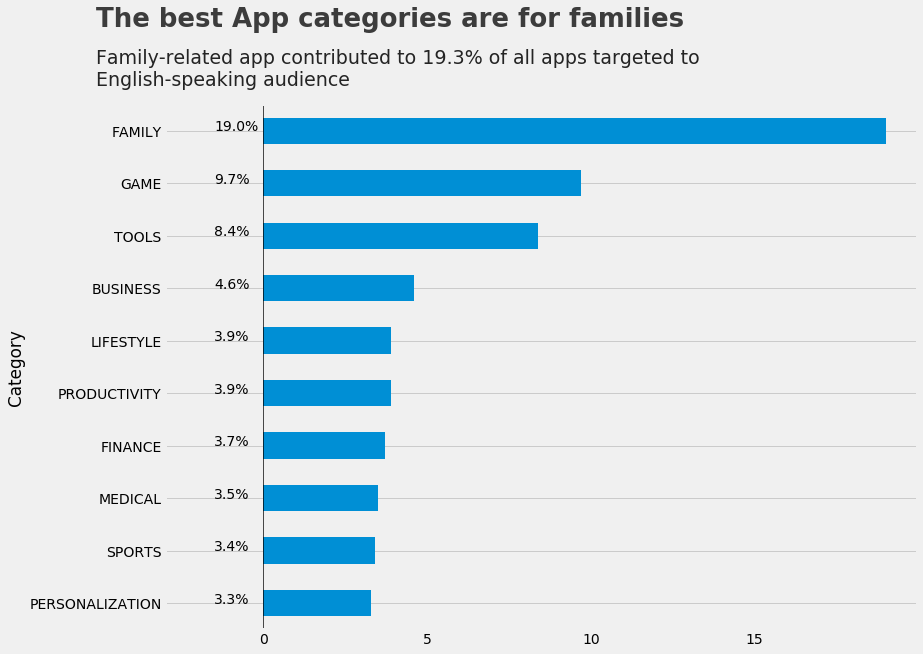

In [15]:
## Visualize and format the plot

main_title = "The best App categories are for families"
subttitle = 'Family-related app contributed to 19.3% of all apps targeted to\nEnglish-speaking audience'
texts = [main_title,subttitle]


fig, ax = plt.subplots()
plot_obj = fx.barh_plot(df=topX_categories, ax=ax, x='Category', y='percent',figsize=(12,9))
plot_obj = fx.do_headings(plot_obj,fig,what=['main_heading','sub_heading'],texts=texts)
ax.grid(False,axis='x')
fx.change_xlim(plot_obj,-3)
fx.label_bars(plot_obj,df=topX_categories)
ax.legend().remove()


### Q2 : what are the top 10 genres by the average number of installs?

In [21]:
# before processing, cinvert the text values in Installs to numerical values
# use lowercase name, 'installs' to represents the converted values

enApps['installs'] = enApps['Installs'].apply(lambda x: fx.convert_install_2_nums(x))

D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [44]:

topX = 10
topX_genres = enApps[['Genres','App','installs']]
#topX_genres['Installs'] = topX_genres['Installs'].apply(lambda x: fx.convert_install_2_nums(x))

topX_genres = topX_genres.groupby(by='Genres').mean().reset_index()
topX_genres = topX_genres.sort_values(by='installs',ascending=False)[:topX]
topX_genres['percent'] = topX_genres['installs'].apply(lambda x: round(x/float(topX_genres.installs.sum()) * 100,1))
topX_genres = fx.sort_bars(topX_genres)
topX_genres.head(topX)

,Genres,installs,percent
0,Productivity,1.673896e+07,7.2
1,Educational;Action & Adventure,1.701667e+07,7.3
2,Photography,1.773767e+07,7.6
3,Puzzle;Action & Adventure,1.836667e+07,7.8
4,Casual,1.963096e+07,8.4
5,Arcade,2.288837e+07,9.8
6,Social,2.325365e+07,9.9
7,Video Players & Editors,2.479007e+07,10.6
8,Adventure;Action & Adventure,3.533333e+07,15.1
9,Communication,3.832263e+07,16.4


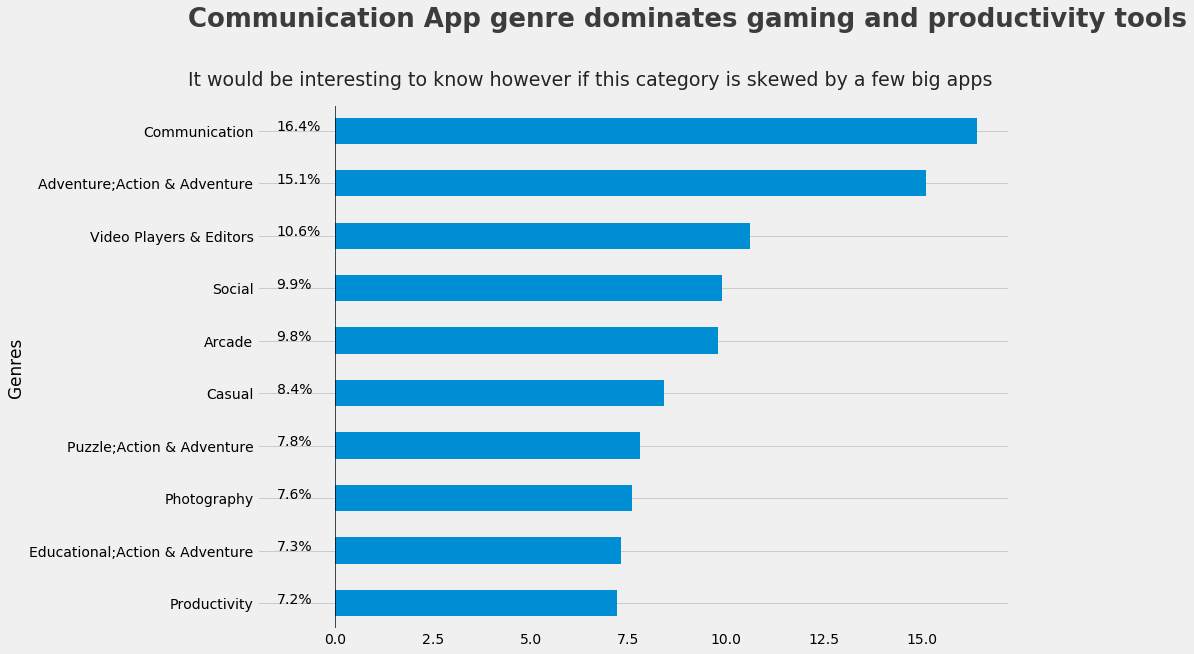

In [24]:
main_title = "Communication App genre dominates gaming and productivity tools"
subttitle = 'It would be interesting to know however if this category is skewed by a few big apps'
texts = [main_title,subttitle]

fig, ax = plt.subplots()
plot_obj = fx.barh_plot(df=topX_genres, ax=ax, x='Genres', y='percent',figsize=(12,9))
fx.do_headings(plot_obj,fig,what=['main_heading','sub_heading'],texts=texts)
ax.grid(False,axis='x')
fx.change_xlim(plot_obj,-2)
fx.label_bars(plot_obj,df=topX_genres)
ax.legend().remove()


### Q3: what is are the top 5 apps within the most popular genre?

In [43]:

topX =10
popular_genre='Communication'

top_CommuncationApps = enApps[['Genres','App','installs']][enApps['Genres']==popular_genre]
top_CommuncationApps.sort_values(by='installs',ascending=False,inplace=True)
top_CommuncationApps.head(topX)  # the top 10 Apps in the communication genres

,Genres,App,installs
451,Communication,Gmail,1000000000
411,Communication,Google Chrome: Fast & Secure,1000000000
464,Communication,Hangouts,1000000000
336,Communication,WhatsApp Messenger,1000000000
391,Communication,Skype - free IM & video calls,1000000000
382,Communication,Messenger – Text and Video Chat for Free,1000000000
4676,Communication,Viber Messenger,500000000
371,Communication,Google Duo - High Quality Video Calls,500000000
383,Communication,imo free video calls and chat,500000000
403,Communication,LINE: Free Calls & Messages,500000000


### Next Steps...

### Conclusion

In this project we we analysed data from Google Play in order to make recomendations for App Developers of developing for that market.
From the results, it appears that in the braoder categories of apps, family-realted ones have a greaer appeal to users. 